# Navy Data Prep

- compile data with incremental changes
- analyze any potential batch effects
- clean up annotations

In [1]:
from datetime import datetime; print("START:", datetime.now())
import socket; print("Simons Foundation, Rusty HPC,", socket.gethostname())

START: 2021-10-22 13:54:40.209127
Simons Foundation, Rusty HPC, worker3124


In [2]:
%cd /mnt/home/zzhang/ceph/CHARM-AlternativeSplicing
%load_ext rpy2.ipython
!mkdir -p data-V9/compiled

/mnt/ceph/users/zzhang/CHARM-AlternativeSplicing


In [3]:
import os
from tqdm import tqdm
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from multiprocessing import Pool
from jemm import rmats_helper, suppa_helper
from jemm import kallisto_helper
from jemm.junction import JunctionCountTable
from jemm.transcript import TranscriptMeasureTable

In [4]:
DATA_VER = 'data-V9'
as_types = ['RI', 'A5SS', 'A3SS', 'SE']
enable_rmats_compilation = False
enable_suppa_compilation = False

In [5]:
# prep for junction count measures
rmats_dir = '/mnt/home/zzhang/ceph/My-RNASeq-pipeline/NAVY_CHARM_20200816/rmats'
jct_dict = {}

if enable_rmats_compilation:
    merged_dict = rmats_helper.merge_rmats_runs(
        run1_dir = os.path.join(rmats_dir, 'FOO'),
        run2_dir = os.path.join(rmats_dir, 'FOO_V7'),
        #minimum_sanity_checker = rmats_helper.get_min_sanity_checker(min_avg_count=5, min_avg_psi=0.01, max_avg_psi=0.99),
        as_types = as_types
    )
    if DATA_VER == 'data-V8' or DATA_VER == 'data-V9':
        merged_dict = rmats_helper.merge_rmats_runs(
            run1_dir = os.path.join(rmats_dir, 'FOO_V8'),
            run2_dir = merged_dict,
            #minimum_sanity_checker = rmats_helper.get_min_sanity_checker(min_avg_count=5, min_avg_psi=0.01, max_avg_psi=0.99),
            as_types = as_types
        )
    
    if DATA_VER == 'data-V9':
        merged_dict = rmats_helper.merge_rmats_runs(
            run1_dir = os.path.join(rmats_dir, 'FOO_V9'),
            run2_dir = merged_dict,
            #minimum_sanity_checker = rmats_helper.get_min_sanity_checker(min_avg_count=5, min_avg_psi=0.01, max_avg_psi=0.99),
            as_types = as_types
        )        
    
    for as_type in as_types:
        save_fp = './%s/compiled/jct_%s.pkl'%(DATA_VER, as_type) if as_type!='SE' else \
            './%s/compiled/jct_%s.txt'% (DATA_VER, as_type)
        if not os.path.isfile(save_fp):
            jct_dict[as_type] = JunctionCountTable.from_darts(
                file=merged_dict[as_type], 
                b1=merged_dict['b1'], 
                b2=merged_dict['b2']
            )
            if as_type != 'SE':
                pickle.dump(jct_dict[as_type], open(save_fp, 'wb'))
            else:
                df = jct_dict[as_type].data.applymap(lambda x: x.to_plaintext())
                df.to_csv(save_fp, sep="\t")

        else:
            print("reload %s" % as_type)
            if as_type != 'SE':
                jct_dict[as_type] = pickle.load(open(save_fp, 'rb'))
            else:
                jct_dict[as_type] = JunctionCountTable.from_plaintext(save_fp)
    for as_type in jct_dict:
        jct_dict[as_type].data.to_csv('%s/matrix/%s-JCT.txt'%(DATA_VER, as_type), sep="\t")
        
else:
    print('Skip junction compilation')

Skip junction compilation


In [6]:
if enable_suppa_compilation:
    txr_dict = {}
    for as_type in as_types:
        save_fp = './%s/compiled/txr_%s.pkl'%(DATA_VER,as_type) if as_type!='SE' else \
            './%s/compiled/txr_%s.txt'%(DATA_VER,as_type)
        if not os.path.isfile(save_fp):
            print(as_type)
            txr_dict[as_type] = TranscriptMeasureTable.from_kallisto_hdf5(
                wd="/mnt/home/zzhang/ceph/My-RNASeq-pipeline/NAVY_CHARM_20200816/kallisto/",
                event_type=as_type,
                index_file="/mnt/home/zzhang/ceph/SUPPA/index/hg38/suppa_gencodev34_%s_strict.ioe"%as_type,
                nthreads=12,
                #minimum_sanity_checker=suppa_helper.get_min_sanity_checker(min_avg_psi=0, max_avg_psi=1, max_nan_ratio=0.5)
            )
            if as_type != 'SE':
                pickle.dump(txr_dict[as_type], open(save_fp, 'wb'))
            else:
                df = txr_dict[as_type].data.applymap(lambda x: x.to_plaintext())
                df.to_csv(save_fp, sep="\t")
        else:
            #pass
            if as_type != 'SE':
                txr_dict[as_type] = pickle.load(open(save_fp, 'rb'))
            else:
                txr_dict[as_type] = TranscriptMeasureTable.from_plaintext(save_fp)
    for as_type in txr_dict:
        txr_dict[as_type].data.to_csv('%s/matrix/%s-TXR.txt'%(DATA_VER, as_type), sep="\t")
else:
    print('Skip transcript compilation')

Skip transcript compilation


In [7]:
import pandas as pd
gexp = pd.read_table("%s/All_rsem_tpm.%s.txt" % (DATA_VER, DATA_VER.split('-')[1]) )
gexp.head()

,20_0001-T00_P1,20_0002-T00_P1,20_0002-T28_P4,20_0003-T00_P3,20_0003-T00_P4,20_0003-T28_P4,20_0004-T00_P1,20_0004-T00_P10,20_0004-T00_P11,20_0004-T00_P12,...,20_3381-T00_P24,20_3381-T07_P24,20_3381-T10_P24,20_3381-T14_P24,20_3381-T42_P24,20_3381-T49_P24,20_3381-T56_P24,20_3395-T00_P25,20_3395-T46_P25,20_3395-T56_P25
ENSG00000000003.14,4.00,4.0,3.0,0.00,1.00,4.0,2.0,2.00,2.00,2.0,...,0.0,3.00,1.00,2.00,1.00,7.00,4.0,14.00,0.00,16.00
ENSG00000000005.6,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.0,...,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00
ENSG00000000419.12,241.00,207.0,245.0,169.00,259.00,225.0,184.0,209.00,261.00,185.0,...,0.0,293.00,316.00,286.00,208.00,255.00,250.0,612.00,482.00,538.00
ENSG00000000457.14,333.25,286.3,334.3,311.48,399.88,353.1,241.1,206.66,229.58,171.1,...,0.0,364.05,301.69,318.21,261.46,301.25,214.9,654.88,609.29,479.53
ENSG00000000460.17,21.75,32.7,49.7,41.52,40.12,52.9,25.9,47.34,41.42,38.9,...,0.0,54.95,50.31,68.90,40.54,57.75,47.1,48.12,102.71,115.47


In [8]:
from collections import defaultdict
sid_to_col = defaultdict(list)
for c in gexp.columns:
    sid = "_".join(c.split("_")[0:2])
    sid_to_col[sid].append(c)

print(len(sid_to_col))
print(sid_to_col['20_0033-T00'])

1909
['20_0033-T00_P1']


In [9]:
pooled_exp = {}
for sid in sid_to_col:
    pooled_exp[sid] = gexp[sid_to_col[sid]].mean(axis=1)

pooled_exp_df = pd.DataFrame.from_dict(pooled_exp)
pooled_exp_df.head()

,20_0001-T00,20_0002-T00,20_0002-T28,20_0003-T00,20_0003-T28,20_0004-T00,20_0005-T00,20_0005-T28,20_0006-T00,20_0006-T28,...,20_3381-T00,20_3381-T07,20_3381-T10,20_3381-T14,20_3381-T42,20_3381-T49,20_3381-T56,20_3395-T00,20_3395-T46,20_3395-T56
ENSG00000000003.14,4.00,4.0,3.0,0.50,4.0,2.222222,3.00,1.00,3.00,6.00,...,0.0,3.00,1.00,2.00,1.00,7.00,4.0,14.00,0.00,16.00
ENSG00000000005.6,0.00,0.0,0.0,0.00,0.0,0.000000,0.00,0.00,0.00,0.00,...,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00
ENSG00000000419.12,241.00,207.0,245.0,214.00,225.0,211.555556,294.00,258.00,283.00,188.00,...,0.0,293.00,316.00,286.00,208.00,255.00,250.0,612.00,482.00,538.00
ENSG00000000457.14,333.25,286.3,334.3,355.68,353.1,205.261111,412.56,407.11,500.04,335.14,...,0.0,364.05,301.69,318.21,261.46,301.25,214.9,654.88,609.29,479.53
ENSG00000000460.17,21.75,32.7,49.7,40.82,52.9,34.850000,59.44,58.89,34.96,40.86,...,0.0,54.95,50.31,68.90,40.54,57.75,47.1,48.12,102.71,115.47


In [10]:
meta = pd.read_csv("%s/charm_master.csv" % DATA_VER, sep="\t" if DATA_VER in ('data-V8', 'data-V9') else ",")
meta['IgG_call'] =  [x.split('|')[-1] if type(x) is str else "Unknown" for x in meta['IgG_call']]
meta['IgM_call'] =  [x.split('|')[-1] if type(x) is str else "Unknown" for x in meta['IgM_call']]
meta = meta.rename(columns={'RNAseq_plate': 'plateNum'})
meta['plateNum'] = meta['plateNum'].str.replace('?', '')

meta = meta.drop_duplicates().set_index('sid')
meta = meta.loc[meta.index.isin(pooled_exp_df.columns)]
meta = meta.loc[~meta.final.isnull()]
meta = meta.loc[~meta.Sex.isnull()]
meta = meta.loc[~meta['plateNum'].isnull()]

meta['plateNum'] = ['Multiple' if ';' in x else x for x in meta['plateNum']]

meta = meta.dropna(axis=1)
#meta = meta.loc[meta.index.isin(gexp.columns)]
meta['final'].replace({'First_Mid': 'First'}, inplace=True)
meta['final'].replace({'Mid_post': 'Mid'}, inplace=True)
meta['final'].replace({'Immune +': 'Immune'}, inplace=True)

meta = meta.loc[~meta['final'].isin(['Unclear', 'Pending', 'Late'])]
meta = meta.loc[meta['final'].isin(['Control', 'Pre', 'First', 'Mid', 'Post'])]


black_list_sids = []
# remove outliers; retrospective analyses from splicing PSI PCA
black_list_sids = ['20_1811-T49', '20_0246-T00', '20_3381-T00']
# remove mislabeled Post samples
black_list_sids += ['20_0627-T56',
'20_0628-T56',
'20_0629-T56',
'20_0630-T56']
meta = meta.loc[~meta.index.isin(black_list_sids)]
print(meta.shape)
print(meta['plateNum'].value_counts())
print(meta['final'].value_counts())

meta.to_csv("%s/charm_master.clean.csv"%DATA_VER)
meta.head()

/mnt/home/zzhang/workspace/programs/anaconda3/envs/rna-seq/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (9,16,25,55,62,63,64,66,67,68) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(1548, 11)
Multiple    143
P18          86
P24          84
P22          83
P23          83
P19          82
P20          81
P21          81
P17          78
P9           74
P10          73
P25          72
P16          65
P14          61
P8           61
P15          60
P5           55
P6           50
P3           50
P7           49
P13          41
P12          20
P4           11
P2R           5
Name: plateNum, dtype: int64
Post       548
Mid        532
Control    310
First      101
Pre         57
Name: final, dtype: int64


,pid,Sex,T0_date,tp,plateNum,final,Age,Study_Type,FutureUse,IgG_call,IgM_call
sid,,,,,,,,,,,
20_0149-T00,149,M,05/11/2020,0,P3,Control,19.0,Long,Yes,Neg,Neg
20_0149-T28,149,M,05/11/2020,28,P8,Pre,19.0,Long,Yes,Neg,Pos
20_0150-T00,150,M,05/11/2020,0,P3,Control,19.0,Long,Yes,Neg,Neg
20_0151-T00,151,M,05/11/2020,0,P3,Control,22.0,Long,Yes,Neg,Pos
20_0152-T00,152,M,05/11/2020,0,P3,Control,19.0,Long/Sub,Yes,Neg,Neg


## Get the batch effect using RNA-seq data

## 1. Read in and Clean up the data

Will do the following:
- read in gene expression (RSEM) matrix and pool the plates by average
- intersect meta data with RNA-seq samples, because some entries in metadata does not have RNA-seq

In [11]:
from jemm.meta_loader import MetaLoader
from jemm.covariate import Contrasts, Covariate

data_files = {
    'SE': {
        'jct': './%s/compiled/jct_SE.txt' % DATA_VER,
        'txr': './%s/compiled/txr_SE.txt' % DATA_VER
    }, 
    'A5SS': {
        'jct': './%s/compiled/jct_A5SS.pkl' % DATA_VER,
        'txr': './%s/compiled/txr_A5SS.pkl' % DATA_VER
    }, 
    'A3SS': {
        'jct': './%s/compiled/jct_A3SS.pkl'% DATA_VER,
        'txr': './%s/compiled/txr_A3SS.pkl'% DATA_VER
    }, 
    'RI': {
        'jct': './%s/compiled/jct_RI.pkl'% DATA_VER,
        'txr': './%s/compiled/txr_RI.pkl'% DATA_VER
    }
}

contrasts = Contrasts(name="final", levels=[
    'Control', 
    'Pre',
    'First',
    'Mid',
    'Post',
])
covs = Covariate(
                 fp="./%s/charm_master.clean.csv" % DATA_VER, 
                 sep=",", 
                 index_col=0,
                 contrasts=contrasts,
                 main_effects=['final', 'Sex'],
                 factor_conversion={
                     'final': {
                         'First': 'final@First',
                         'Mid': 'final@Mid',
                         'Post': 'final@Post',
                         'Pre': 'final@Pre',
                     },
                     'Sex': {'M': 'Sex@M'}
                 },
                 verbose=True
             )

metaloader = MetaLoader(covariates=covs, data_files=data_files, reg_tables=None,
                       jem_kwargs={'diff_intercept_by_measure':True},
                       verbose=True)

loading SE..
loaded n=(47686, 1947) jct, n=(47847, 1947) txr
loading A5SS..
loaded n=(3804, 1947) jct, n=(17687, 1947) txr
loading A3SS..
loaded n=(5837, 1947) jct, n=(19353, 1947) txr
loading RI..
loaded n=(3758, 1947) jct, n=(7345, 1947) txr


In [12]:
contrasts = Contrasts(name="final", levels=[
    'Control', 
    'Pre',
    'First',
    'Mid',
    'Post',
])
covs = Covariate(
                 fp="./%s/charm_master.clean.csv" % DATA_VER, 
                 sep=",", 
                 index_col=0,
                 contrasts=contrasts,
                 main_effects=['final', 'Sex'],
                 factor_conversion={
                     'final': {
                         'First': 'final@First',
                         'Mid': 'final@Mid',
                         'Post': 'final@Post',
                         'Pre': 'final@Pre',
                     },
                     'Sex': {'M': 'Sex@M'}
                 },
                 verbose=True
             )
covs.meta.shape

(1548, 11)

In [13]:
pooled_exp_df = pooled_exp_df[[x for x in meta.index if x in pooled_exp_df]]
#pooled_exp_df = pooled_exp_df[meta.index]
pooled_exp_df.to_csv("./%s/matrix/All_rsem.gene.tpm_pooled_plate.txt"%DATA_VER)
pooled_exp_df.head()

,20_0149-T00,20_0149-T28,20_0150-T00,20_0151-T00,20_0152-T00,20_0152-T28,20_0152-T49,20_0152-T53,20_0152-T56,20_0153-T00,...,20_3376-T10,20_3376-T14,20_3381-T07,20_3381-T10,20_3381-T14,20_3381-T42,20_3381-T56,20_3395-T00,20_3395-T46,20_3395-T56
ENSG00000000003.14,1.00,3.00,7.00,0.00,0.0,2.00,1.00,6.00,6.00,8.00,...,2.0,6.00,3.00,1.00,2.00,1.00,4.0,14.00,0.00,16.00
ENSG00000000005.6,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,...,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00
ENSG00000000419.12,224.00,306.00,209.00,145.00,159.0,221.00,279.00,225.00,214.00,168.00,...,103.0,332.00,293.00,316.00,286.00,208.00,250.0,612.00,482.00,538.00
ENSG00000000457.14,318.54,415.59,296.26,217.18,303.0,307.36,314.74,259.03,262.79,263.76,...,132.8,458.41,364.05,301.69,318.21,261.46,214.9,654.88,609.29,479.53
ENSG00000000460.17,104.46,79.41,44.74,28.82,23.0,26.64,42.26,43.97,19.21,17.24,...,15.2,53.59,54.95,50.31,68.90,40.54,47.1,48.12,102.71,115.47


In [14]:
jct_dfs = {}
txr_dfs = {}
for as_type in metaloader.data:
    print(as_type)
    if os.path.isfile("./%s/matrix/%s-JCT.txt"%(DATA_VER, as_type)):
        df1 = pd.read_table("./%s/matrix/%s-JCT.txt"%(DATA_VER, as_type), index_col=0)[meta.index]
    else:
        df1 = metaloader.data[as_type].junction_measure.applymap(lambda x: x.psi if pd.notna(x) else None)[meta.index]
        df1.to_csv("./%s/matrix/%s-JCT.txt"%(DATA_VER, as_type), sep="\t")
    jct_dfs[as_type] = df1
    if os.path.isfile("./%s/matrix/%s-TXR.txt"%(DATA_VER, as_type)):
        df2 = pd.read_table("./%s/matrix/%s-TXR.txt"%(DATA_VER, as_type), index_col=0)[meta.index]
    else:
        df2 = metaloader.data[as_type].transcript_measure.applymap(lambda x: x.psi if pd.notna(x) else None)[meta.index]
        df2.to_csv("./%s/matrix/%s-TXR.txt"%(DATA_VER, as_type), sep="\t")
    txr_dfs[as_type] = df2

SE
A5SS
A3SS
RI


## 2. Demonstration of plate-wise annotation distribution

In [15]:
import pandas as pd
from jemm.covariate import Contrasts, Covariate
contrasts = Contrasts(name="final", levels=[
    'Control', 
    'Pre',
    'First',
    'Mid',
    'Post'
])
covs = Covariate(fp="./%s/charm_master.clean.csv" % DATA_VER, sep=",", 
                 index_col=0,
                 contrasts=contrasts,
                 main_effects=['final', 'Sex'],
             )
meta_ = pd.read_csv("./%s/charm_master.clean.csv" % DATA_VER, index_col=0)
meta_ = meta_.loc[covs.covariate.index]
plate_annot = meta_.groupby(['plateNum', 'final']).size().unstack(fill_value=0)
plate_annot.head()

final,Control,First,Mid,Post,Pre
plateNum,,,,,
Multiple,36,17,35,38,17
P10,24,3,31,14,1
P12,0,0,2,18,0
P13,8,5,6,21,1
P14,4,1,27,25,4


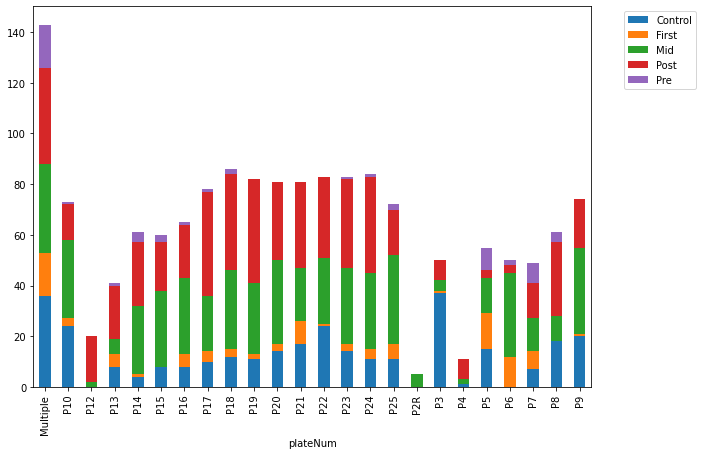

In [16]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize=(10,7))
plate_annot.plot(kind='bar', stacked=True, ax=ax)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

## 3. Perform scaling and  PCA

In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import numpy as np
pca = PCA(n_components=10, random_state=777)
# scale each gene to Z-score
scaled_df = scale(pooled_exp_df, axis=1)
pca.fit(scaled_df)

PCA(n_components=10, random_state=777)

In [18]:
np.var(scaled_df[100,:])

0.9999999999999991

In [19]:
print(pca.explained_variance_ratio_)

[0.11579031 0.02476161 0.02085101 0.01414924 0.00943871 0.00622459
 0.00486667 0.00448622 0.00407867 0.00347869]


In [20]:
pca.components_.shape

(10, 1548)

Text(0, 0.5, 'PC2, 0.025')

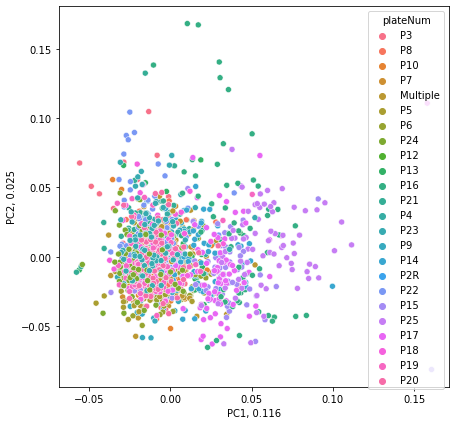

In [21]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
sns.scatterplot(x=pca.components_[0], y=pca.components_[1], hue=meta.loc[pooled_exp_df.columns, 'plateNum'], ax=ax)
ax.set_xlabel("PC1, %.3f"%pca.explained_variance_ratio_[0])
ax.set_ylabel("PC2, %.3f"%pca.explained_variance_ratio_[1])
#ax.get_legend().remove()

In [22]:
# remove outlier
#print(np.where(pca.components_[1]>0.3)) # 512  ## 1007
#pooled_exp_df.iloc[:, [1007, 1058]] # 20_0246-T00 ## 20_1811-T49

Text(0, 0.5, 'PC2, 0.025')

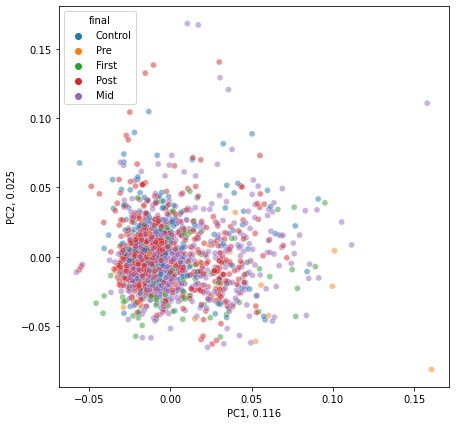

In [23]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
sns.scatterplot(x=pca.components_[0], y=pca.components_[1], hue=meta.loc[pooled_exp_df.columns, 'final'], ax=ax, alpha=0.5)
ax.set_xlabel("PC1, %.3f"%pca.explained_variance_ratio_[0])
ax.set_ylabel("PC2, %.3f"%pca.explained_variance_ratio_[1])

Text(0, 0.5, 'PC2, 0.025')

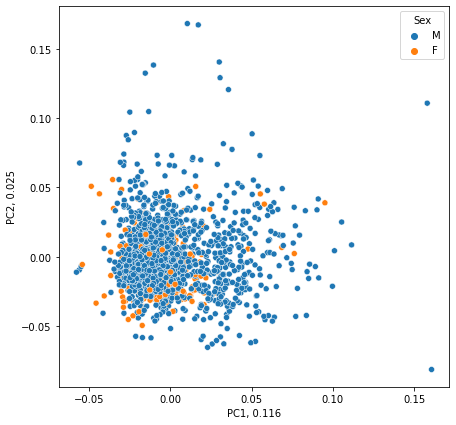

In [24]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
sns.scatterplot(x=pca.components_[0], y=pca.components_[1], hue=meta.loc[pooled_exp_df.columns, 'Sex'], ax=ax)
ax.set_xlabel("PC1, %.3f"%pca.explained_variance_ratio_[0])
ax.set_ylabel("PC2, %.3f"%pca.explained_variance_ratio_[1])

## PCA on all AS types

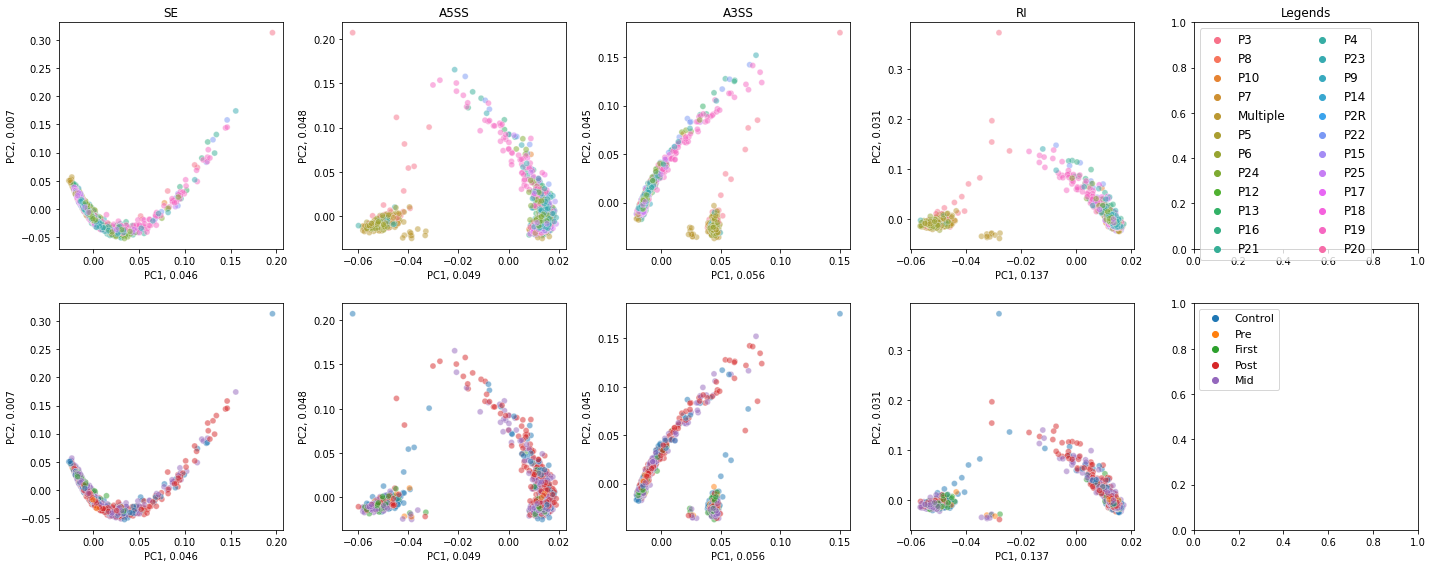

In [25]:
# jct
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
i = 0
for as_type in jct_dfs:
    pca = PCA(n_components=10, random_state=777)
    pca.fit(scale(jct_dfs[as_type].fillna(jct_dfs[as_type].mean(axis=0)).fillna(0.5), axis=1))
    # plate
    sns.scatterplot(x=pca.components_[0], y=pca.components_[1], hue=meta['plateNum'], alpha=0.5, ax=axs[0, i])
    axs[0, i].set_xlabel("PC1, %.3f"%pca.explained_variance_ratio_[0])
    axs[0, i].set_ylabel("PC2, %.3f"%pca.explained_variance_ratio_[1])
    axs[0, i].set_title(as_type)
    axs[0, i].get_legend().remove()
    # condition
    sns.scatterplot(x=pca.components_[0], y=pca.components_[1], hue=meta['final'], alpha=0.5, ax=axs[1, i])
    axs[1, i].set_xlabel("PC1, %.3f"%pca.explained_variance_ratio_[0])
    axs[1, i].set_ylabel("PC2, %.3f"%pca.explained_variance_ratio_[1])
    axs[1, i].get_legend().remove()

    i+=1
axs[0,i].legend(*axs[0,i-1].get_legend_handles_labels(), loc='upper left', fontsize=12, ncol=2)
axs[1,i].legend(*axs[1,i-1].get_legend_handles_labels(), loc='upper left', fontsize=11, ncol=1)
axs[0,i].set_title('Legends')


fig.tight_layout()

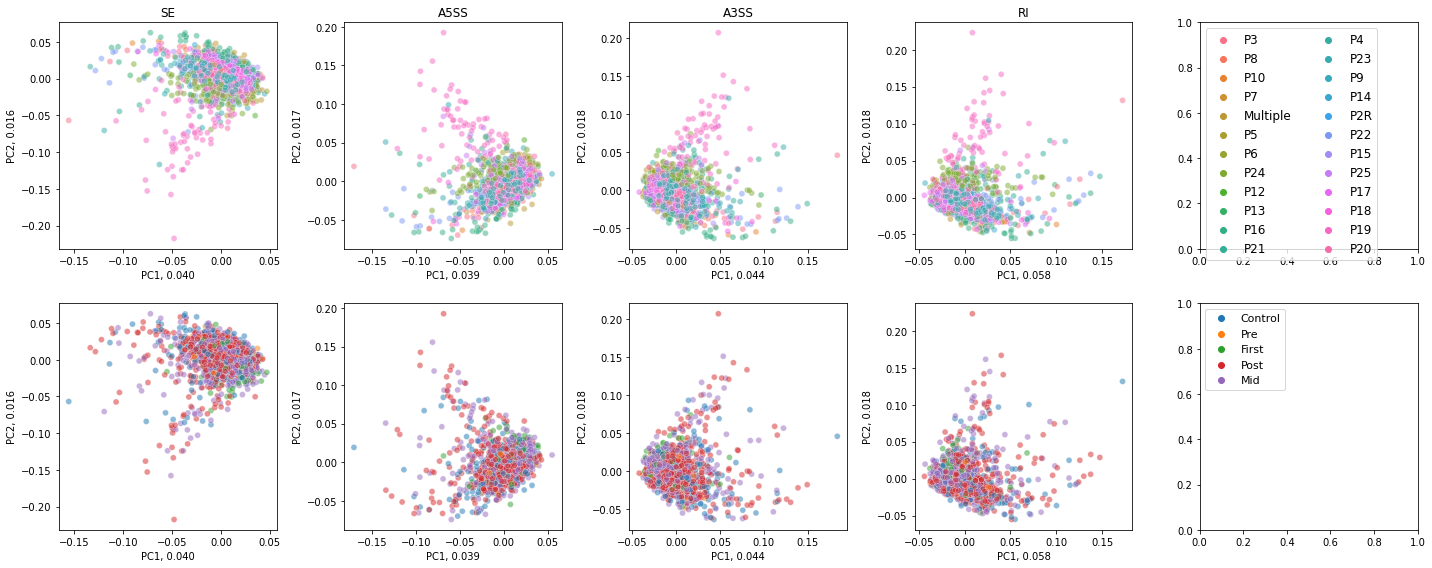

In [26]:
# txr
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
i = 0
for as_type in txr_dfs:
    pca = PCA(n_components=10, random_state=777)
    pca.fit(scale(txr_dfs[as_type].fillna(txr_dfs[as_type].mean(axis=0)).fillna(0.5), axis=1))
    # plate
    sns.scatterplot(x=pca.components_[0], y=pca.components_[1], hue=meta['plateNum'], alpha=0.5, ax=axs[0, i])
    axs[0, i].set_xlabel("PC1, %.3f"%pca.explained_variance_ratio_[0])
    axs[0, i].set_ylabel("PC2, %.3f"%pca.explained_variance_ratio_[1])
    axs[0, i].set_title(as_type)
    axs[0, i].get_legend().remove()
    # condition
    sns.scatterplot(x=pca.components_[0], y=pca.components_[1], hue=meta['final'], alpha=0.5, ax=axs[1, i])
    axs[1, i].set_xlabel("PC1, %.3f"%pca.explained_variance_ratio_[0])
    axs[1, i].set_ylabel("PC2, %.3f"%pca.explained_variance_ratio_[1])
    axs[1, i].get_legend().remove()

    i+=1
axs[0,i].legend(*axs[0,i-1].get_legend_handles_labels(), loc='upper left', fontsize=12, ncol=2)
axs[1,i].legend(*axs[1,i-1].get_legend_handles_labels(), loc='upper left', fontsize=11, ncol=1)
fig.tight_layout()

## 4. Write new metadata with top PCs

In [30]:
import scipy.stats as ss
print(meta.shape)
print(txr_dfs['SE'].shape)
pca = PCA(n_components=20, random_state=777)
pca.fit(scale(txr_dfs['SE'].fillna(txr_dfs['SE'].mean(axis=0)).fillna(0.5), axis=1))
pcs = []
for i in range(len(pca.components_)):
    meta["PC%i"%i] = pca.components_[i]
    sp = ss.spearmanr(pca.components_[i], meta['final'])
    sp2 = ss.spearmanr(pca.components_[i], meta['Sex'])
    sp3 = ss.spearmanr(pca.components_[i], meta['Age'])
    sp4 = ss.spearmanr(pca.components_[i], meta['tp'])
    sp5 = ss.spearmanr(pca.components_[i], meta['plateNum'])

    print('PC%i, Final Spearman=%.3f, pval=%.3f' % (i, sp.correlation, sp.pvalue))
    print('      Sex   Spearman=%.3f, pval=%.3f' % (sp2.correlation, sp2.pvalue))
    print('      Age   Spearman=%.3f, pval=%.3f' % (sp3.correlation, sp3.pvalue))
    print('      TP    Spearman=%.3f, pval=%.3f' % (sp4.correlation, sp4.pvalue))
    print('      plate Spearman=%.3f, pval=%.3f' % (sp5.correlation, sp5.pvalue))
    #if sp.pvalue > 0.01 and sp2.pvalue > 0.01 and sp3.pvalue > 0.01:
    if sp.pvalue > 0.05:
        pcs.append(i)
print('PCs w/o strong corr.: %s' % pcs)

(1548, 31)
(47847, 1548)
PC0, Final Spearman=-0.049, pval=0.053
      Sex   Spearman=-0.143, pval=0.000
      Age   Spearman=0.046, pval=0.073
      TP    Spearman=-0.134, pval=0.000
      plate Spearman=-0.040, pval=0.111
PC1, Final Spearman=0.076, pval=0.003
      Sex   Spearman=-0.014, pval=0.569
      Age   Spearman=0.045, pval=0.076
      TP    Spearman=0.080, pval=0.002
      plate Spearman=-0.157, pval=0.000
PC2, Final Spearman=-0.072, pval=0.005
      Sex   Spearman=0.201, pval=0.000
      Age   Spearman=-0.099, pval=0.000
      TP    Spearman=0.084, pval=0.001
      plate Spearman=0.021, pval=0.417
PC3, Final Spearman=0.127, pval=0.000
      Sex   Spearman=0.055, pval=0.030
      Age   Spearman=-0.071, pval=0.005
      TP    Spearman=0.102, pval=0.000
      plate Spearman=0.063, pval=0.014
PC4, Final Spearman=0.085, pval=0.001
      Sex   Spearman=-0.111, pval=0.000
      Age   Spearman=0.209, pval=0.000
      TP    Spearman=-0.030, pval=0.236
      plate Spearman=-0.041, pval

In [31]:
meta.to_csv("%s/charm_master.clean_w_10pc.csv" % DATA_VER)

## Index and Store Data for Multi processing

In [46]:
from jemm.model import JointExonModel

PCS_TO_INCL = "0,9"
USE_RE = True
DATA_VER = "data-V9"

%run ./notebooks/navy_utils.py $DATA_VER $PCS_TO_INCL $USE_RE
%run 

print("Disease model: %s" % covs.formula)

for as_type in as_types:
    print(as_type)
    # init jemm
    jem = JointExonModel(junction_measure=jct_dfs[as_type], 
               transcript_measure=txr_dfs[as_type], 
               covariates=covs,
               diff_intercept_by_measure=True,
               group_varname='pid',
               min_groupvar=0.001, 
               optimizer='bfgs'
    )
    
    jem.transcript_measure.index.name = "sid"
    jem.transcript_measure.to_csv(f"{DATA_VER}/compiled/txr_{as_type}.txt", sep="\t", na_rep='nan')
    
    jem.junction_measure.index.name = "sid"
    jem.junction_measure.to_csv(f"{DATA_VER}/compiled/jct_{as_type}.txt", sep="\t", na_rep='nan')

navy_utils.py data-V9 ['PC0', 'PC9'] True
Disease model: y = final + pid + Sex + plateNum + PC0 + PC9
RI
A5SS
A3SS
SE


In [32]:
print("FINISH:", datetime.now())

FINISH: 2021-10-22 15:39:43.776020
